# **Notebook: Double Descent**

Nombre:

Numero de estudiante:

---

Esta notebook investiga el fenómeno **double descent** que ocurre en las Redes Neuronales.

En el aprendizaje automático, a menudo esperamos que a medida que la capacidad de un modelo (por ejemplo, el número de parámetros) aumenta, el error de entrenamiento disminuya y el error de prueba eventualmente aumente después de cierto punto (el clásico "overfitting"). Sin embargo, el fenómeno de Double Descent desafía esta intuición al mostrar que, en ciertos escenarios, a medida que la capacidad del modelo continúa aumentando más allá del punto de overfitting, el error de prueba puede volver a disminuir.

En esta notebook:

- Utilizamos el dataset MNIST-1D que se puede encontrar en https://github.com/greydanus/mnist1d.
- Entrenamos redes con diferentes capacidades (variando el número de unidades ocultas)
- Analizamos cómo el ruido en las etiquetas del conjunto de entrenamiento influye en la forma de la curva Double Descent.

## Dataset

In [64]:
# Instalar el dataset MNIST 1D
!pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-poppr3es
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-poppr3es
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [65]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
import random
random.seed(0)

DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cuda


In [66]:
def get_noisy_mnist1d_dataset(noise_rate=0.0):
    """
    Generates the MNIST-1D dataset with a specified amount of noise in the training labels.

    Args:
        noise_rate (float): The proportion of training labels to flip randomly.

    Returns:
        dict: A dictionary containing the noisy dataset.
    """
    args = mnist1d.data.get_dataset_args()
    args.num_samples = 8000
    args.train_split = 0.5
    args.corr_noise_scale = 0.25
    args.iid_noise_scale = 2e-2
    data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl',
                                    download=False, regenerate=True)

    # Add noise to training labels
    for c_y in range(len(data['y'])):
        random_number = random.random()
        if random_number < noise_rate:
            random_int = int(random.random() * 10)
            data['y'][c_y] = random_int

    return data

In [67]:
data = get_noisy_mnist1d_dataset(noise_rate=0.0)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Dimensionality of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 4000
Dimensionality of each example: 40


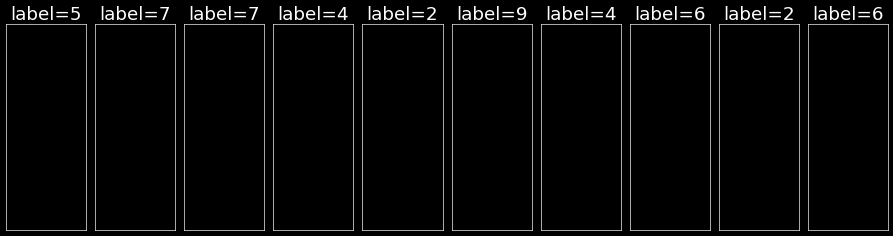

In [68]:
def plot_signals(xs, t, labels=None, ratio=2.6, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig


# Sample 10 random examples from test
num_test_examples = len(data['y_test'])
sample_indices_test = random.sample(range(num_test_examples), 10)

xs = data['x_test'][sample_indices_test]
labels = data['y_test'][sample_indices_test]
t = data['t']
_ = plot_signals(xs, t, labels=labels, ratio=2.7, zoom=6)

Ahora definiremos la función `get_model`, encargada de construir nuestra red neuronal.

**Tarea:**
Completa la función `get_model` con las siguientes especificaciones:

1. Define las dimensiones:
    * Entrada (D_i): debe coincidir con la dimensionalidad de cada muestra del dataset MNIST-1D.
    * Oculta (n_hidden): se recibe como argumento de la función.
    * Salida (D_o): igual al número de clases.

2. Crea una arquitectura secuencial con las siguientes capas:
    - Capa lineal de entrada.
    - Activación ReLU.
    - Capa lineal oculta.
    - Activación ReLU.
    - Capa lineal de salida.

3. Devuelve el modelo resultante.

In [69]:
def get_model(n_hidden):

  D_i = len(data['x'][0])            # Input dimensions
  D_k = n_hidden                    # Hidden dimensions
  D_o = data['y'].max().item()+1              # Output dimensions

  # Completar
  model = nn.Sequential(
      nn.Linear(D_i, D_k),
      nn.ReLU(),
      nn.Linear(D_k, D_k),
      nn.ReLU(),
      nn.Linear(D_k, D_o)
  )
  
  return model


## Entrenamiento y visualización de la curva *Double Descent*

En esta sección vamos a explorar cómo varían el **error de entrenamiento** y el **error de prueba** al aumentar la capacidad de una red neuronal.

**Tu tarea:**

1. Entrena redes neuronales con distintos números de unidades ocultas (`n_hidden`) durante **1000 épocas**, usando los siguientes tamaños de capa oculta:  
   `[2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250]`.  
2. Registra los errores finales de entrenamiento y prueba para cada modelo.  
3. Grafica los errores en función del número de unidades ocultas para visualizar la **curva de Double Descent**.  
4. Añade una línea vertical que marque el **interpolation threshold**, que se puede representar como el punto en que el número de parámetros del modelo se aproxima al número de ejemplos de entrenamiento. El pico del error de prueba suele aparecer cerca de esta región.

> 💡 **Nota:** la ejecución del código puede tomar un tiempo considerable, ¡así que quizás sea un buen momento para tomar un descanso!


In [70]:
# Su código aqui
def train_model(model, data, n_epochs=1000, batch_size=64, learning_rate=1e-3):

    # Preparar los datos
    x_train = torch.tensor(data['x'], dtype=torch.float32)
    y_train = torch.tensor(data['y'], dtype=torch.long)
    x_test = torch.tensor(data['x_test'], dtype=torch.float32)
    y_test = torch.tensor(data['y_test'], dtype=torch.long)

    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Definir el optimizador y la función de pérdida
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    model.to(DEVICE)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        accuracy = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            # 1. Corregir el typo: de =+ a +=
            accuracy += (outputs.argmax(dim=1) == y_batch).sum().item() ### <-- CORREGIDO (era =+)


        avg_loss = total_loss / len(train_loader)
        avg_accuracy = accuracy / len(train_dataset) # Esto da una fracción (ej: 0.95)

        # Evaluar el modelo
        model.eval()
        correct = 0
        total = 0
        loss_test = 0
        final_test_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
                outputs = model(x_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
                loss_test += criterion(outputs, y_batch).item()
        final_test_loss = loss_test / len(test_loader)
        accuracy_test = 100 * correct / total
        
            
        if (epoch+1) % 100 == 0 or epoch == 0:
            # 2. Multiplicar por 100 para mostrar el porcentaje
            print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {avg_loss:.4f}, Test Loss: {final_test_loss:.4f}, Train Accuracy: {avg_accuracy * 100:.2f}%, Test Accuracy: {accuracy_test:.2f}%') ### <-- CORREGIDO (añadido * 100)

    final_train_loss = avg_loss
    final_train_accuracy = avg_accuracy*100
    

    return final_train_loss, final_test_loss, final_train_accuracy, accuracy_test

In [94]:
# Generamos lista de neuronas en espacio geometrico

hidden_neurons_list = np.geomspace(2, 300, dtype=int, num=13)
print("Hidden Neurons List:", hidden_neurons_list)

Hidden Neurons List: [  2   3   4   6  10  16  24  37  56  85 130 197 300]


In [72]:
# Entrenamos y evaluamos modelos con diferentes números de neuronas ocultas
#hidden_neurons_list = [2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250]

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for n_hidden in hidden_neurons_list:
    print(f'Training model with {n_hidden} hidden neurons...')
    model = get_model(n_hidden)
    train_loss, test_loss, train_accuracy, test_accuracy = train_model(model, data)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Training model with 2 hidden neurons...
Epoch [1/1000], Train Loss: 2.4017, Test Loss: 2.3878, Train Accuracy: 10.30%, Test Accuracy: 9.70%
Epoch [100/1000], Train Loss: 1.7130, Test Loss: 1.7215, Train Accuracy: 29.25%, Test Accuracy: 30.12%
Epoch [200/1000], Train Loss: 1.6830, Test Loss: 1.6905, Train Accuracy: 30.53%, Test Accuracy: 30.88%
Epoch [300/1000], Train Loss: 1.6707, Test Loss: 1.6799, Train Accuracy: 30.98%, Test Accuracy: 31.15%
Epoch [400/1000], Train Loss: 1.6641, Test Loss: 1.6732, Train Accuracy: 31.40%, Test Accuracy: 31.70%
Epoch [500/1000], Train Loss: 1.6590, Test Loss: 1.6663, Train Accuracy: 31.45%, Test Accuracy: 31.85%
Epoch [600/1000], Train Loss: 1.6542, Test Loss: 1.6609, Train Accuracy: 31.87%, Test Accuracy: 32.30%
Epoch [700/1000], Train Loss: 1.6513, Test Loss: 1.6584, Train Accuracy: 32.25%, Test Accuracy: 32.52%
Epoch [800/1000], Train Loss: 1.6490, Test Loss: 1.6560, Train Accuracy: 32.70%, Test Accuracy: 32.48%
Epoch [900/1000], Train Loss: 1.6486

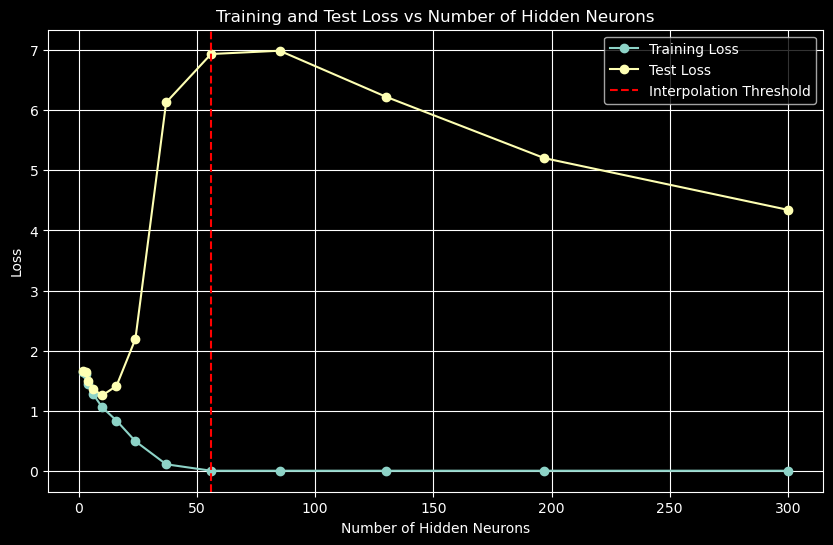

In [98]:
# Plotear las pérdidas de entrenamiento y prueba
plt.figure(figsize=(10, 6))
plt.plot(hidden_neurons_list, train_losses, marker='o', label='Training Loss')
plt.plot(hidden_neurons_list, test_losses, marker='o', label='Test Loss')
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Number of Hidden Neurons')

# Ploteamos el interpolation threshold, aproximadamente en 56 neuronas
plt.axvline(x=56, color='r', linestyle='--', label='Interpolation Threshold')
plt.legend()
plt.grid(True)
plt.show()

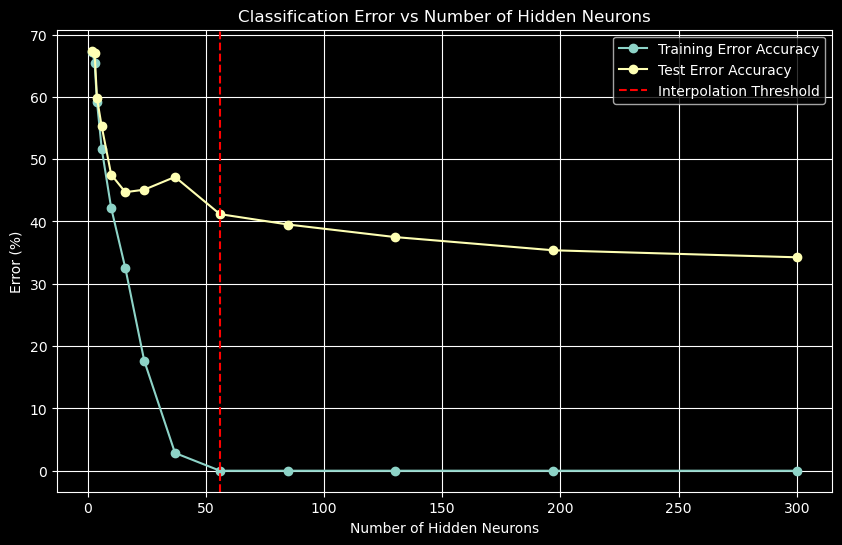

In [99]:
# Plotear los resultados de  Classification Error 
plt.figure(figsize=(10, 6))
plt.plot(hidden_neurons_list, [100 - i for i in train_accuracies], marker='o', label='Training Error Accuracy')
plt.plot(hidden_neurons_list, [100 - i for i in test_accuracies], marker='o', label='Test Error Accuracy')
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Error (%)')
plt.title('Classification Error vs Number of Hidden Neurons')

# Ploteamos el interpolation threshold, aproximadamente en 56 neuronas
plt.axvline(x=56, color='r', linestyle='--', label='Interpolation Threshold')
plt.legend()
plt.grid(True)
plt.show()

## Explorando el *Double Descent* con etiquetas ruidosas

En esta sección repetiremos el experimento anterior, pero introduciendo **ruido en las etiquetas** del conjunto de entrenamiento para analizar cómo afecta al fenómeno *Double Descent*.

Entrenaremos nuevamente el modelo con los mismos tamaños de capa oculta:  
`[2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250]`,  
pero esta vez usaremos datasets en los que un porcentaje de las etiquetas ha sido aleatorizado. Realizaremos el experimento con dos niveles de ruido: **10 %** y **30 %**.

Después de entrenar los modelos para cada nivel de ruido, graficaremos las curvas de error de entrenamiento y prueba, similar a como lo hicimos anteriormente.

**Tu tarea:**

1. Ejecuta la celda siguiente para cargar los datasets con **10 %** y **30 %** de ruido.  
2. Adapta el código de entrenamiento y visualización de la sección anterior para entrenar los modelos con los conjuntos ruidosos y graficar los resultados.


In [75]:
# Carga el dataset MNIST-1D con 10% de ruido en las etiquetas de entrenamiento
data_noisy_10 = get_noisy_mnist1d_dataset(noise_rate=0.10)

# Puedes imprimir información sobre el dataset ruidoso para verificarlo
print("Dataset con 10% de ruido:")
print("Ejemplos en entrenamiento:", len(data_noisy_10['y']))
print("Ejemplos en prueba:", len(data_noisy_10['y_test']))
print("-" * 20)

# Repite el proceso para el 30% de ruido (modificando la tasa de ruido)
data_noisy_30 = get_noisy_mnist1d_dataset(noise_rate=0.30)

print("Dataset con 30% de ruido:")
print("Ejemplos en entrenamiento:", len(data_noisy_30['y']))
print("Ejemplos en prueba:", len(data_noisy_30['y_test']))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Dataset con 10% de ruido:
Ejemplos en entrenamiento: 4000
Ejemplos en prueba: 4000
--------------------
Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Dataset con 30% de ruido:
Ejemplos en entrenamiento: 4000
Ejemplos en prueba: 4000


In [76]:
# Adaptamos el código para entrenar y evaluar modelos con los datasets ruidosos
def evaluate_on_noisy_data(data_noisy, hidden_neurons_list):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for n_hidden in hidden_neurons_list:
        print(f'Training model with {n_hidden} hidden neurons on noisy data...')
        model = get_model(n_hidden) 
        train_loss, test_loss, train_accuracy, test_accuracy = train_model(model, data_noisy)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [78]:
#Entrenamos modelo con data ruidosa al 10%
train_losses_10, test_losses_10, train_accuracies_10, test_accuracies_10 = evaluate_on_noisy_data(data_noisy_10, hidden_neurons_list)


Training model with 2 hidden neurons on noisy data...
Epoch [1/1000], Train Loss: 2.4072, Test Loss: 2.3738, Train Accuracy: 10.05%, Test Accuracy: 10.15%
Epoch [100/1000], Train Loss: 1.8501, Test Loss: 1.7213, Train Accuracy: 28.73%, Test Accuracy: 31.00%
Epoch [200/1000], Train Loss: 1.8129, Test Loss: 1.6919, Train Accuracy: 29.68%, Test Accuracy: 31.77%
Epoch [300/1000], Train Loss: 1.7910, Test Loss: 1.6809, Train Accuracy: 29.78%, Test Accuracy: 32.42%
Epoch [400/1000], Train Loss: 1.7877, Test Loss: 1.6797, Train Accuracy: 30.00%, Test Accuracy: 32.50%
Epoch [500/1000], Train Loss: 1.7873, Test Loss: 1.6794, Train Accuracy: 30.25%, Test Accuracy: 32.27%
Epoch [600/1000], Train Loss: 1.7867, Test Loss: 1.6778, Train Accuracy: 29.68%, Test Accuracy: 32.30%
Epoch [700/1000], Train Loss: 1.7836, Test Loss: 1.6785, Train Accuracy: 30.25%, Test Accuracy: 32.38%
Epoch [800/1000], Train Loss: 1.7859, Test Loss: 1.6782, Train Accuracy: 29.83%, Test Accuracy: 32.42%
Epoch [900/1000], Tra

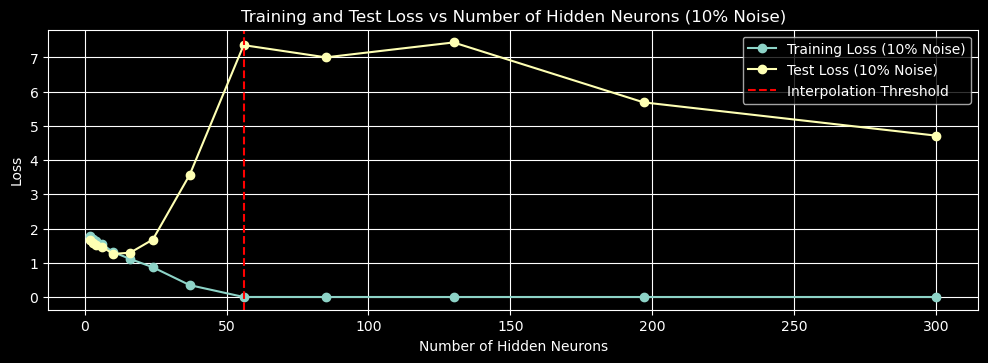

In [100]:
# Plotear las pérdidas de entrenamiento y prueba para los datasets ruidosos
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(hidden_neurons_list, train_losses_10, marker='o', label='Training Loss (10% Noise)')
plt.plot(hidden_neurons_list, test_losses_10, marker='o', label='Test Loss (10% Noise)')
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Number of Hidden Neurons (10% Noise)')

# Ploteamos el interpolation threshold, aproximadamente en 56 neuronas
plt.axvline(x=56, color='r', linestyle='--', label='Interpolation Threshold')
plt.legend()
plt.grid(True)

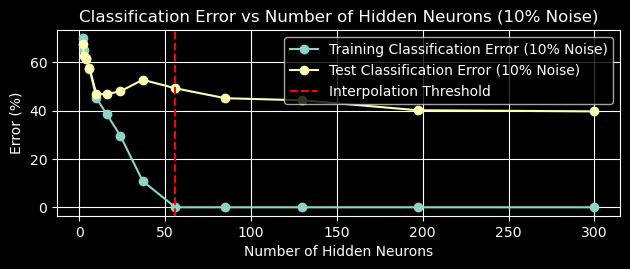

In [101]:
#Ploteamos los resultados de accuracy para 10% de ruido en las etiquetas
plt.subplot(2, 1, 2)
plt.plot(hidden_neurons_list, [100 - i for i in train_accuracies_10], marker='o', label='Training Classification Error (10% Noise)')
plt.plot(hidden_neurons_list, [100 - i for i in test_accuracies_10], marker='o', label='Test Classification Error (10% Noise)')
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Error (%)')
plt.title('Classification Error vs Number of Hidden Neurons (10% Noise)')

# Ploteamos el interpolation threshold, aproximadamente en 56 neuronas
plt.axvline(x=56, color='r', linestyle='--', label='Interpolation Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
#Entrenamos para el 30% de ruido en las etiquetas
train_losses_30, test_losses_30, train_accuracies_30, test_accuracies_30 = evaluate_on_noisy_data(data_noisy_30, hidden_neurons_list)

 

Training model with 2 hidden neurons on noisy data...


Epoch [1/1000], Train Loss: 2.3095, Test Loss: 2.3002, Train Accuracy: 9.80%, Test Accuracy: 9.88%
Epoch [100/1000], Train Loss: 2.0477, Test Loss: 1.8650, Train Accuracy: 25.45%, Test Accuracy: 30.15%
Epoch [200/1000], Train Loss: 2.0245, Test Loss: 1.8147, Train Accuracy: 26.90%, Test Accuracy: 31.40%
Epoch [300/1000], Train Loss: 2.0107, Test Loss: 1.7965, Train Accuracy: 26.95%, Test Accuracy: 32.05%
Epoch [400/1000], Train Loss: 2.0031, Test Loss: 1.7879, Train Accuracy: 27.27%, Test Accuracy: 32.48%
Epoch [500/1000], Train Loss: 2.0013, Test Loss: 1.7835, Train Accuracy: 27.05%, Test Accuracy: 32.23%
Epoch [600/1000], Train Loss: 2.0016, Test Loss: 1.7857, Train Accuracy: 27.10%, Test Accuracy: 32.20%
Epoch [700/1000], Train Loss: 1.9990, Test Loss: 1.7871, Train Accuracy: 26.82%, Test Accuracy: 32.02%
Epoch [800/1000], Train Loss: 2.0000, Test Loss: 1.7841, Train Accuracy: 26.90%, Test Accuracy: 32.40%
Epoch [900/1000], Train Loss: 2.0010, Test Loss: 1.7829, Train Accuracy: 26.9

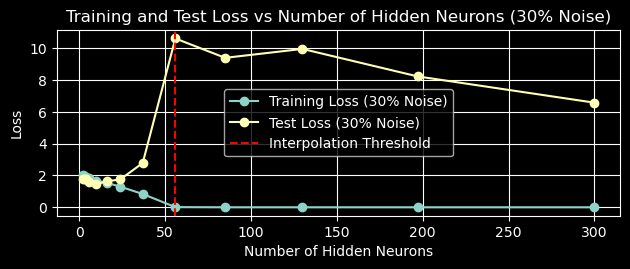

In [102]:
# Plotear las pérdidas de entrenamiento y prueba para los datasets ruidosos
plt.subplot(2, 1, 2)
plt.plot(hidden_neurons_list, train_losses_30, marker='o', label='Training Loss (30% Noise)')
plt.plot(hidden_neurons_list, test_losses_30, marker='o', label='Test Loss (30% Noise)')
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Number of Hidden Neurons (30% Noise)')

# Ploteamos el interpolation threshold, aproximadamente en 56 neuronas
plt.axvline(x=56, color='r', linestyle='--', label='Interpolation Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() 

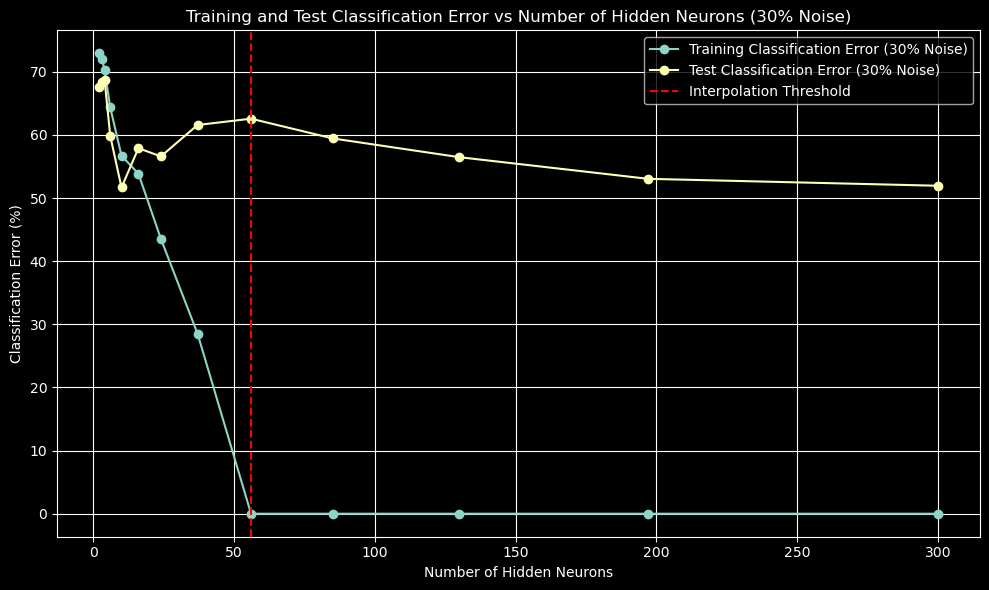

In [103]:
#Ploteamos las accuracies para el 30% de ruido en las etiquetas
#Ploteamos el interpolation threshold
plt.figure(figsize=(10, 6))
plt.plot(hidden_neurons_list, [100 - i for i in train_accuracies_30], marker='o', label='Training Classification Error (30% Noise)')
plt.plot(hidden_neurons_list, [100 - i for i in test_accuracies_30], marker='o', label='Test Classification Error (30% Noise)')
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Classification Error (%)')
plt.title('Training and Test Classification Error vs Number of Hidden Neurons (30% Noise)')

# Ploteamos el interpolation threshold, aproximadamente en 56 neuronas
plt.axvline(x=56, color='r', linestyle='--', label='Interpolation Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Preguntas finales

1. ¿Cómo afecta el **ruido en las etiquetas** al error mínimo de entrenamiento alcanzable? ¿Por qué ocurre esto?  

El ruido de las etiquetas no afecta al error mìnimo de entrenamiento alcanzable. Se pueden observar en los graficos que tanto para 10% de ruido como para 30% de ruido, el _interpolation threshold_ se consigue con aproximadamente 56 neuronas en la capa oculta. Esto ocurre porque el ruido en el error, no cambia de fondo que el _interpolation threshold_ o el error minimo de entrenamiento (0% Error Train) se alcanza cuando el modelo tiene la capacidad paramètrica de "memorizar" todos los datos de entrenamiento.

2. Según tus observaciones, ¿cómo influye el **ruido en las etiquetas** en el fenómeno de *Double Descent*, especialmente en relación con la **capacidad del modelo** y su **capacidad de generalización**?  

Se puede observar en los tres experimentos hechos con 0%, 10% y 30% de ruido en las etiquetas que el ruido en las etiquetas hace que la etapa previa al descenso doble sea mas pronunciada con un pico mayor. El Màximo de este suele darse en el interpolation threshold como se puede observar en las gràficas.

Al final de todo, se observa que el ruido en las etiquetas hace que los modelos tengan peores capacidades para las mismas complejidades de modelo. Esto se puede apreciar claramente visualizando las graficas de errores de clasificacion, donde los modelos con menos ruido en las etiquetas son los que performan mejor bajo esta mètrica.

3. En *Deep Learning*, ¿es lo mismo el **overfitting** durante el entrenamiento que la **sobreparametrización** de los modelos? Explica las diferencias.

La sobreparametrizaciòn de un modelo es cuando se tiene màs paràmetros que datos de entrenamiento, mientras que el sobreajuste es un fenòmeno que ocurre cuando el modelo aprende todos los datos hasta los datos con ruido, haciendo que generalize peor con datos no vistos. 

La conclusion que se puede sacar con estos experimentos es que a pesar de que una sobreparametrizaciòn pueda causar sobre ajuste, el fenomeno double descent muestra que modelos sobreparametrizados pueden seguir mejorando sus errores de clasificacion, y romper con la idea clasica de cuando se para de entrenar un modelo y la clasica disyuntiva entre Bias y Variance.
